# Projet 4

___Décryptage / Nettoyage des données___

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
import matplotlib.dates as mdates
import scipy.stats as st

from jupyterthemes import jtplot
jtplot.style(theme="chesterish",grid=False)

In [2]:
df_customers=pd.read_csv('customers.csv')
df_products=pd.read_csv('products.csv')
df_transactions=pd.read_csv('transactions.csv')

Retirons les valeurs "test" (pour lesquels les produits correspondants avaient un prix de -1 euros) et convertissons les dates en objet date dans notre fichiers de transactions.

In [3]:
df_transactions=df_transactions[df_transactions.id_prod!='T_0']
df_transactions['date']=pd.to_datetime(df_transactions.date)

On s'apperçoit que 4 clients (sûrement des revendeurs) achètent un nombre bien supérieur d'articles, on décide de les mettre dans un fichiers de transactions à part.

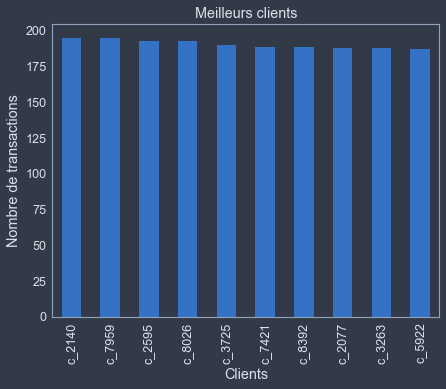

In [10]:
df_transactions['client_id'].value_counts(dropna=False).head(10).reset_index().plot(x='index',
                                                                                    kind='bar',
                                                                                   legend=False)

plt.xlabel('Clients')
plt.ylabel('Nombre de transactions')
plt.title('Meilleurs clients')
plt.tight_layout()
plt.savefig('Meilleurs clients')
plt.show()


In [5]:
df_big_clients=df_transactions.loc[(df_transactions['client_id'] == 'c_4958') |
                                   (df_transactions['client_id'] =='c_3454') |
                                   (df_transactions['client_id'] == 'c_6714') | 
                                   (df_transactions['client_id'] == 'c_1609')]

df_transactions=df_transactions.loc[(df_transactions['client_id'] != 'c_4958') &
                                    (df_transactions['client_id'] !='c_3454') & 
                                    (df_transactions['client_id'] != 'c_6714') &
                                    (df_transactions['client_id'] != 'c_1609')]

Créons un dataframe regroupant toutes nos données, ajoutons une colonne âge et une colonne jour d'achat.

In [6]:
df_transactions_m=pd.merge(pd.merge(df_transactions,df_products,on='id_prod',how='left'),
                           df_customers,on='client_id',how='left')
df_big_clients_m=pd.merge(pd.merge(df_big_clients,df_products,on='id_prod',how='left'),
                          df_customers,on='client_id',how='left')

df_transactions_m['age']=df_transactions_m.date.max().year-df_transactions_m['birth']

df_transactions_m['Day'] = [d.date() for d in df_transactions_m['date']]
df_transactions_m['Day']=pd.to_datetime(df_transactions_m.Day)

print(df_transactions_m['price'].sum()) ; print(df_big_clients_m['price'].sum().round())
CA_total=(df_transactions_m['price'].sum() + df_big_clients_m['price'].sum()).round()
print('Le chiffre d affaire total est :' , CA_total)

5362672.96
433905.0
Le chiffre d affaire total est : 5796578.0


In [7]:
df_transactions_m.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,Day
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,45,2021-04-10
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,f,2000,22,2022-02-03
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,f,1979,43,2021-09-23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,m,1963,59,2021-10-17
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,f,1980,42,2021-07-17


Le jour de la semaine, l'heure d'achat ou le moment de l'année ont-il une influence sur les ventes ? Non pas vraiment.

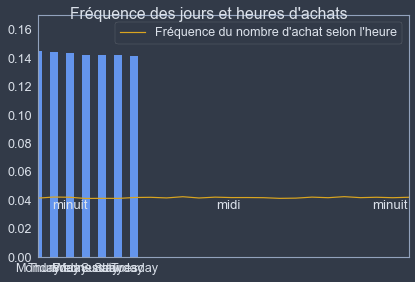

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

color='cornflowerblue'

df_transactions_m.date.dt.weekday_name.value_counts(normalize=True).plot(kind='bar',
                                                                         figsize=(4,4),
                                                                        color=color,ax=ax)

df_transactions_m.date.dt.hour.value_counts(normalize=True).sort_index().plot(kind='line',
                                                                              figsize=(6,4),
                                                                              color='goldenrod',
                                                                             )
                                                                             
plt.text(0.04, 0.2, "minuit",transform=plt.gca().transAxes)
plt.text(0.48, 0.2, "midi",transform=plt.gca().transAxes)
plt.text(0.9, 0.2, "minuit",transform=plt.gca().transAxes)
    
plt.tight_layout() #otherwise the figure is trimmed when saved
plt.suptitle("Fréquence des jours et heures d'achats")
plt.ylim(0,0.17)
plt.title('')
plt.legend(["Fréquence du nombre d'achat selon l'heure"])
plt.savefig("Jours et heures d'achat")
plt.show()

On s'apperçoit que le produit 0_2245 n'a pas de prix (non présent dans le fichier de produit), cela représente 103 transactions quand même. On décide de lui appliquer le prix moyen des produits de la catégorie 0.

In [12]:
df_products.loc[df_products['id_prod']=='0_2245']

,id_prod,price,categ


In [13]:
prix_moy_cat0=df_transactions_m[df_transactions_m.categ==0]['price'].mean()
df_transactions_m['price']=df_transactions_m['price'].fillna(prix_moy_cat0)
df_transactions_m['categ']=df_transactions_m['categ'].fillna(0)
prix_moy_cat0

10.645049776862342

Vérifions que notre CA total a bien augmenté d'environ 1000 euros ( 103 * 10,6 euros), c'est bien le cas.

In [14]:
print(df_transactions_m['price'].sum()) ; print(df_big_clients_m['price'].sum().round())
CA_total=(df_transactions_m['price'].sum() + df_big_clients_m['price'].sum()).round()
print('Le chiffre d affaire total est :' , CA_total)

5363726.819927907
433905.0
Le chiffre d affaire total est : 5797632.0


--------------------
catégorie numéro : 0.0


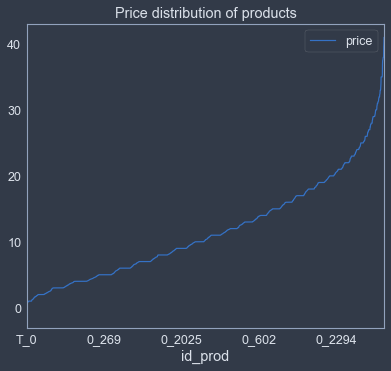

--------------------
catégorie numéro : 2.0


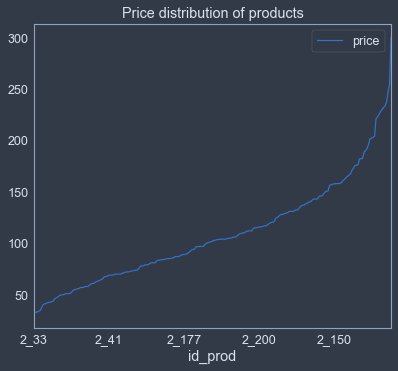

--------------------
catégorie numéro : 1.0


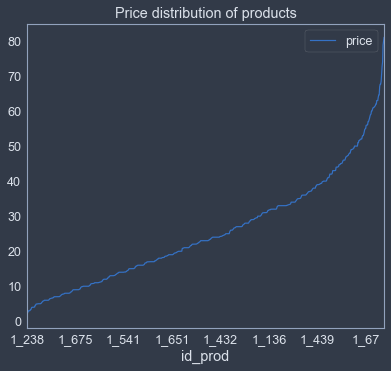

In [15]:
for cat in df_transactions_m['categ'].unique():
    subset=df_transactions_m[df_transactions_m['categ']==cat]
    print(20*"-")
    print('catégorie numéro :',cat)
    df_products.loc[df_products['categ']==cat].sort_values(by='price').plot(x='id_prod',y='price')

    plt.title('Price distribution of products')

    plt.show()

In [16]:
df_transactions_m.loc[(df_transactions_m['categ']==2.0) &
                      (df_transactions_m['price']>=204) &
                      (df_transactions_m['price']<=220)]

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,Day


Par exemple, on s'apperçoit que les produits de la catégorie 2 n'ont pas de prix entre 204 et 220 euros. De manière plus générale, les produits ayant les prix les plus élevés par catégorie ont des prix qui augmentent de façon exponentielle...

Gardons néanmoins un fichier global avec tous nos clients.

In [17]:
df_transac=pd.read_csv('transactions.csv')
df_transac=df_transac[df_transac.id_prod!='T_0']
df_transac_m=pd.merge(pd.merge(df_transac,df_products,on='id_prod',how='left'),
                      df_customers,on='client_id',how='left')
df_transac_m['date']=pd.to_datetime(df_transac_m.date)
df_transac_m['age']=df_transac_m.date.max().year-df_transac_m['birth']
df_transac_m['Day'] = [d.date() for d in df_transac_m['date']]
df_transac_m['Day']=pd.to_datetime(df_transac_m.Day)

#le produit 0_2245 n'a pas de prix, la jointure a donc affecté "NaN" au prix, 
#on lui affecte le prix moyen de la catégorie correspondante
df_transac_m['price']=df_transac_m['price'] \
                        .fillna(df_transac_m[df_transac_m.categ==0]['price']
                        .mean())

In [18]:
df_transac_m.shape

(336816, 10)

In [19]:
df_transac_m.drop_duplicates().shape

(336816, 10)

___Analyse des données___

Etude des catégories: les produits de catégorie 2 sont ceux à fort prix, les 0 et 1 sont moins cher mais se différencient sur un critère différent du prix.

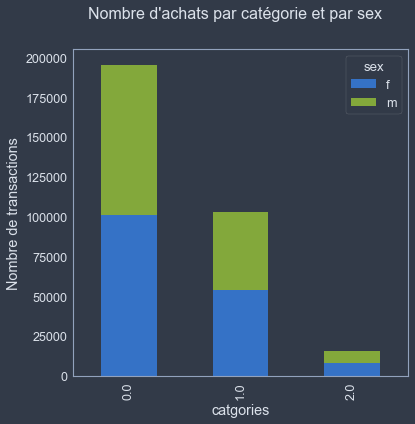

In [20]:
categ_table = pd.crosstab(index=df_transactions_m["categ"], columns=df_transactions_m["sex"])

categ_table.plot(kind="bar",figsize=(6,6),stacked=True)

plt.suptitle("Nombre d'achats par catégorie et par sex", size=16)
plt.xlabel("catgories")
plt.ylabel("Nombre de transactions")
plt.savefig("Nombre d'achats par catégorie et par sex")
plt.show()

Et pour ce qui est du chiffre d'affaire:

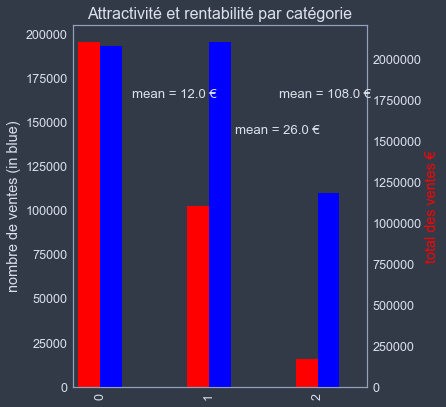

In [35]:
fig = plt.figure()

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

width = 0.2

ax.set_ylabel('nombre de ventes (in blue)')
ax2.set_ylabel('total des ventes €', color='red')

df_transactions_m['categ'].value_counts().plot(kind='bar',ax=ax,position=1,color='red',width=width)
df_transactions_m.groupby(['categ'])['price'].sum().reset_index().plot(y='price',kind='bar',ax=ax2,position=0,color='blue',legend=False,width=width)

means_categ=df_products.pivot_table(columns=['categ'],aggfunc=np.mean ,values=['price'])
plt.text(0.20, 0.80, "mean = {} €".format((means_categ.iloc[:,0][0]).round()),transform=plt.gca().transAxes)
plt.text(0.55, 0.70, "mean = {} €".format((means_categ.iloc[:,1][0]).round()),transform=plt.gca().transAxes)
plt.text(0.70, 0.80, "mean = {} €".format((means_categ.iloc[:,2][0]).round()),transform=plt.gca().transAxes)

plt.tight_layout()
plt.title('Attractivité et rentabilité par catégorie', size=16)
plt.savefig('Attractivité et rentabilité par catégorie')
plt.show() 

In [36]:
df_day = pd.crosstab(index = df_transac_m['Day'], columns = df_transac_m['categ'], values = df_transac_m['price'], aggfunc = sum)
df_day.columns = ['0', '1', '2']
df_day.head()

,0,1,2
Day,,,
2021-03-01,6259.66,6811.53,3345.05
2021-03-02,6715.28,5627.15,2995.04
2021-03-03,6112.06,5691.41,2948.28
2021-03-04,5888.49,6098.98,3059.62
2021-03-05,5969.99,7071.21,4132.21


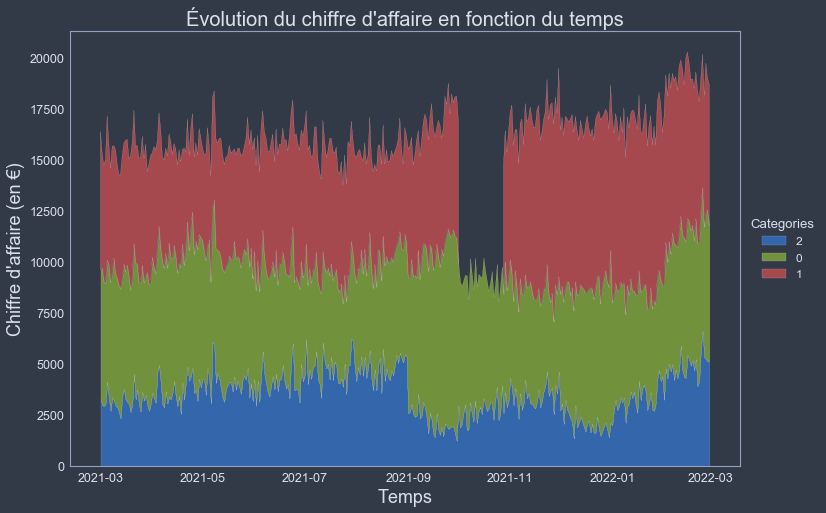

In [37]:
plt.figure(figsize=(12, 8))
plt.stackplot(df_day.index,[df_day['2'],df_day['0'],df_day['1']],
              labels=['2','0','1'],edgecolor='w',alpha=0.8)

plt.xlabel("Temps",fontsize=18)
plt.ylabel("Chiffre d'affaire (en €)",fontsize=18)
plt.title("Évolution du chiffre d'affaire en fonction du temps",fontsize=20)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12,title='Categories')
plt.savefig("Évolution du chiffre d'affaire en fonction du temps")
plt.show()

In [38]:
df_day[(df_day.index >= '2021-10-01') &
       (df_day.index <= '2021-10-31')]['1'].value_counts(dropna=False)

NaN         26
 7003.79     1
 6425.18     1
 6317.99     1
 7261.67     1
 6753.69     1
Name: 1, dtype: int64

On se rend ainsi compte que les produits de la catégorie 1 n'ont pas généré de revenues du 2 au 27 octobre.

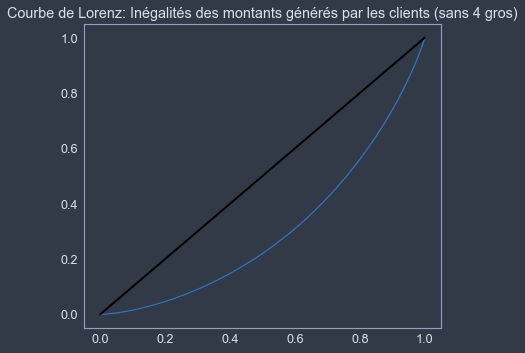

Indice de gini: 0.395


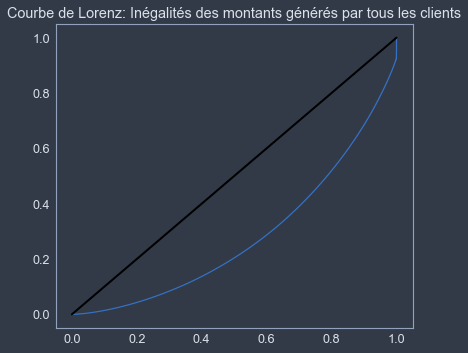

Indice de gini: 0.44


In [39]:
def lor(df,title):
    cat = df.values
    lorenz = np.cumsum(np.sort(cat)) / cat.sum()
    lorenz = np.append([0],lorenz) 

    plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post')
    plt.plot([0, 1], [0,1], linewidth=2, color='black')   
    plt.title(title)
    plt.show()

    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) 
    S = 0.5 - aire_ss_courbe 
    gini = 2*S

    return print('Indice de gini:',gini.round(3))

clients=df_transactions_m.groupby(['client_id'])['price'].sum().reset_index()

#courbe de Lorenz avec le fichier retiré des gros clients
lor(clients['price'],'Courbe de Lorenz: Inégalités des montants générés par les clients (sans 4 gros)')

#courbe de Lorenz avec le fichier global de clients
clients_all=df_transac_m.groupby(['client_id'])['price'].sum().reset_index()
lor(clients_all['price'],'Courbe de Lorenz: Inégalités des montants générés par tous les clients')

Une cassure bien nette apparait avec les 4 gros clients qui représentent une partie substantielle des achats.

Quels sont les produits qui générent le plus de CA ?

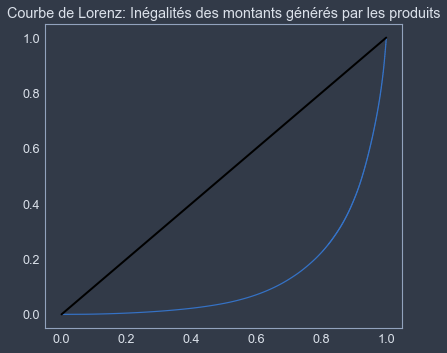

Indice de gini: 0.738
--------------------
Product 2_135 has been sold 449 times
Product 2_112 has been sold 424 times
Product 2_102 has been sold 443 times
Product 1_369 has been sold 1015 times
Product 2_209 has been sold 347 times
Product 1_395 has been sold 828 times
Product 2_110 has been sold 385 times
Product 2_166 has been sold 101 times
Product 1_383 has been sold 801 times
Product 1_414 has been sold 966 times


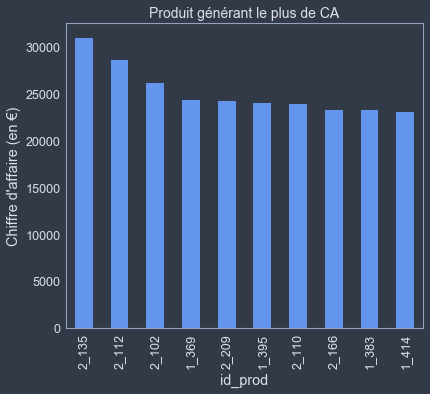

In [40]:
products=df_transactions_m.groupby(['id_prod'])['price'].sum().reset_index()
lor(products['price'],'Courbe de Lorenz: Inégalités des montants générés par les produits')

print(20*"-")
prod_ct_sum=df_transactions_m.pivot_table(index=['id_prod'],aggfunc=('count','sum'),values=['price'])
prod_ct_sum.columns=['count','sum']
top10=prod_ct_sum.sort_values(by='sum',ascending=False).head(10)

for prod in top10.index:
    print('Product',prod,'has been sold',top10['count'][prod],'times')

top10.plot(y='sum',kind='bar',legend=False,color=color)
plt.title('Produit générant le plus de CA',fontsize=14)
plt.ylabel("Chiffre d'affaire (en €)")
plt.savefig("Chiffre d'affaire (en €)")
plt.show()

On se rend ainsi compte que ce sont quasiment 20% des produits qui rapportent 80% du CA.

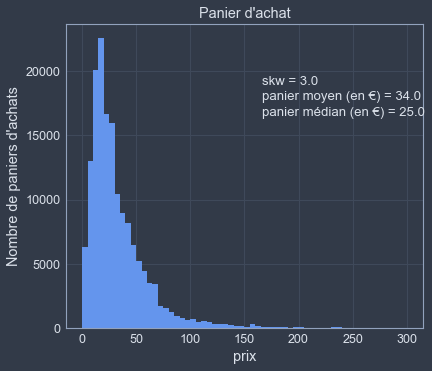

In [41]:
panier=df_transactions_m.groupby(['session_id','client_id'])['price'].sum().reset_index()
panier.hist(bins=60,range= (0,300),color=color)

skw=panier['price'].skew().round()
panier_moyen=round(panier['price'].mean())
panier_médian=round(panier['price'].median())
plt.text(0.55, 0.80, "skw = {}".format(skw),transform=plt.gca().transAxes)
plt.text(0.55, 0.75, "panier moyen (en €) = {}".format(panier_moyen),transform=plt.gca().transAxes)
plt.text(0.55, 0.70, "panier médian (en €) = {}".format(panier_médian),transform=plt.gca().transAxes)


plt.ylabel("Nombre de paniers d'achats")
plt.xlabel('prix')
plt.title("Panier d'achat")
plt.savefig("Panier d'achat")
plt.show()

Etude d'un panier d'achat d'un client. La plupart des paniers des clients sont entre 10 et 40 euros.

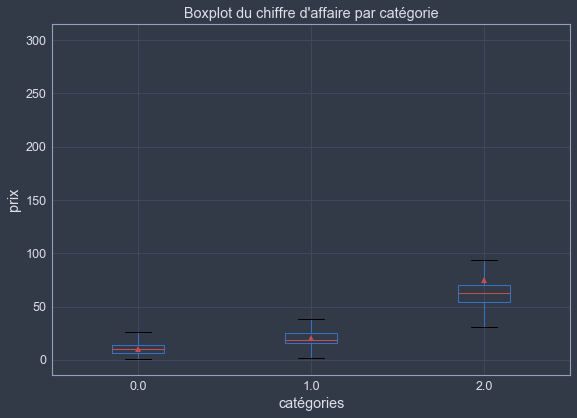

In [42]:
df_transactions_m.boxplot(column="price",by= "categ",figsize= (9,6.5),showmeans=True)   

plt.title("Boxplot du chiffre d'affaire par catégorie")
plt.suptitle("")

plt.xlabel('catégories')
plt.ylabel('prix')
plt.savefig("Boxplot du chiffre d'affaire par catégorie")
plt.show()

___Regardons désormais les relations entre les variables___

In [43]:
#création d'une table avec le nb de transactions par âge et par sexe,
#ainsi que d'une avec les montants, sans distinguer les sexes
df_categ_age_gender_ct=df_transactions_m.pivot_table(index=['sex','age'],columns=['categ'],values=['price'],aggfunc=len)
df_categ_age_gender_ct.columns=['0','1','2']
df_categ_age_gender_ct=df_categ_age_gender_ct.reset_index()

df_categ_age_gender_am=df_transactions_m.pivot_table(index=['age'],columns=['categ'],values=['price'],aggfunc=sum)
df_categ_age_gender_am.columns=['0','1','2']
df_categ_age_gender_am=df_categ_age_gender_am.reset_index().fillna(0)

df_categ_age_gender_ct_F=df_categ_age_gender_ct.loc[df_categ_age_gender_ct['sex']=='f']
df_categ_age_gender_ct_H=df_categ_age_gender_ct.loc[df_categ_age_gender_ct['sex']=='m']

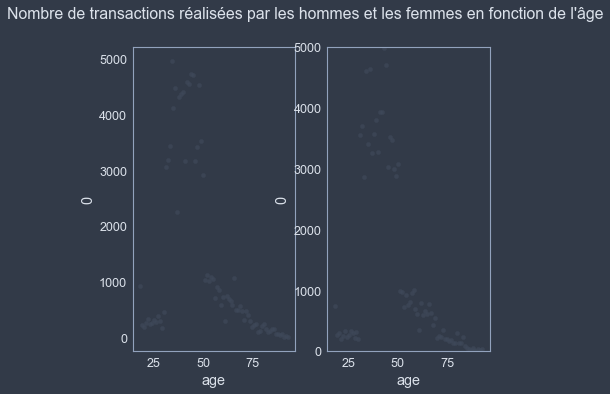

In [46]:
fig,axs=plt.subplots(1,2)

df_categ_age_gender_ct_F.plot(x='age', y='0', kind='scatter',ax=axs[0],alpha=0.7)
plt.suptitle("Nombre de transactions réalisées par les hommes et les femmes en fonction de l'âge")
df_categ_age_gender_ct_H.plot(x='age', y='0', kind='scatter',ax=axs[1],alpha=0.7)
plt.ylim(0,5000)
plt.show()

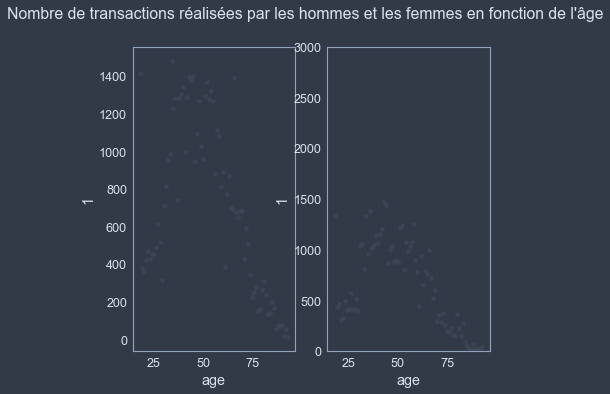

In [47]:
fig,axs=plt.subplots(1,2)


df_categ_age_gender_ct_F.plot(x='age', y='1', kind='scatter',ax=axs[0],alpha=0.7)
plt.suptitle("Nombre de transactions réalisées par les hommes et les femmes en fonction de l'âge")
df_categ_age_gender_ct_H.plot(x='age', y='1', kind='scatter',ax=axs[1],alpha=0.7)
plt.ylim(0,3000)
plt.show()

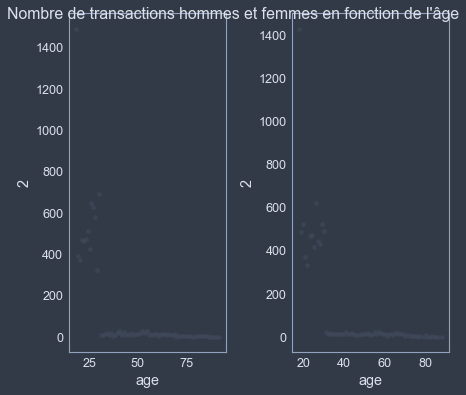

In [48]:
fig,axs=plt.subplots(1,2)

df_categ_age_gender_ct_F.plot(x='age', y='2', kind='scatter',ax=axs[0],alpha=0.7)
plt.suptitle("Nombre de transactions hommes et femmes en fonction de l'âge")
df_categ_age_gender_ct_H.plot(x='age', y='2', kind='scatter',ax=axs[1],alpha=0.7)
plt.tight_layout()
plt.savefig("Nombre de transactions hommes et femmes en fonction de l'âge")
plt.show()

On remarque ainsi que :
    -pour la catégorie 0, ce sont les 30 à 50 qui sont à cibler,
    -pour la catégorie 1, même constat mais de façon moins claire,
    -pour la catégorie 2, ce sont plus les jeunes jusqu'à 30 ans. Grans pic à 18 ans mais cela est sûrement dû au fait qu'il faille avoir au moins 18 ans pour réaliser un achat..      

___Mission 3 : question sur les corrélations___

In [49]:
df_transactions_m[['categ','sex']].assign(sex=df_transactions_m[['categ','sex']].sex.astype('category').cat.codes).corr()

,categ,sex
categ,1.000000,-0.002881
sex,-0.002881,1.000000


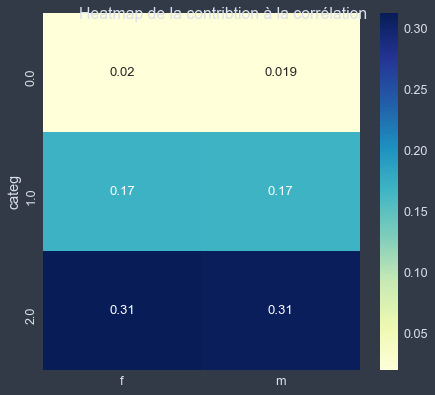

Xi_n= 81.87020170684389


In [52]:
#création du tableau de contingence dans cont
c = df_transac_m[['categ','sex']].pivot_table(index=['categ'],columns=['sex'],aggfunc=len)
cont = c.copy()

tx = df_transac_m['categ'].value_counts()
ty = df_transac_m['sex'].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(df_transac_m)

#création du tableau dans le cas d'indépendance entre sex et categ
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(df_transac_m)
indep = tx.dot(ty.T) / n

c = c.fillna(0) 
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()
sns.heatmap(mesure/xi_n,annot=mesure/xi_n,cmap="YlGnBu")
plt.tight_layout()
plt.suptitle("Heatmap de la contribtion à la corrélation")
plt.title("")
plt.savefig("Heatmap de la contribtion à la corrélation")
plt.show()

print('Xi_n=',xi_n)

Plus les parties sont claires, plus les variables sont corrélées. En revanche comme il n'y a pas de différence de couleurs entre les hommes et les femmes, on peut dire que le sexe influe peu au sein d'une catégorie pour le nombre d'achat (ce qu'on savait déjà, cf graphique au dessus).

In [53]:
from scipy.stats import chi2_contingency

chi2, pvalue, degrees, expected = chi2_contingency(c)
chi2, degrees, pvalue

(81.86933350990711, 2, 1.6683997257127539e-18)

La p-value étant minimale, on en convient que le test est significatif.

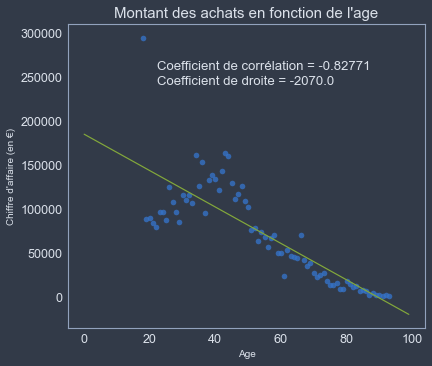

In [54]:
import statsmodels.api as sm

df_categ_age_gender_am.fillna(0)

df_categ_age_gender_am['Total']=df_categ_age_gender_am['0']+df_categ_age_gender_am['1']+df_categ_age_gender_am['2']
plt.plot(df_categ_age_gender_am['age'],df_categ_age_gender_am['Total'],'o',alpha=0.8)

corr_age_montant_achat=(st.pearsonr(df_categ_age_gender_am['age'],df_categ_age_gender_am['Total'])[0]).round(5)
plt.text(0.25, 0.85, "Coefficient de corrélation = {}".format(corr_age_montant_achat),transform=plt.gca().transAxes)

#droite de régression linéaire 
Y = df_categ_age_gender_am['Total']
X = df_categ_age_gender_am[['age']]
X = X.copy() 
X['intercept']=1.
result = sm.OLS(Y, X).fit() 
a,b = result.params['age'],result.params['intercept']

plt.plot(np.arange(100),[a*x+b for x in np.arange(100)])
plt.text(0.25, 0.80, "Coefficient de droite = {}".format(a.round()),transform=plt.gca().transAxes)

plt.xlabel("Age",fontsize=10)
plt.ylabel("Chiffre d'affaire (en €)",fontsize=10)
plt.title("Montant des achats en fonction de l'age",fontsize=15)
plt.savefig("Montant des achats en fonction de l'age")
plt.show()

Forte corrélation (négative) entre l'age et le montant des achats.

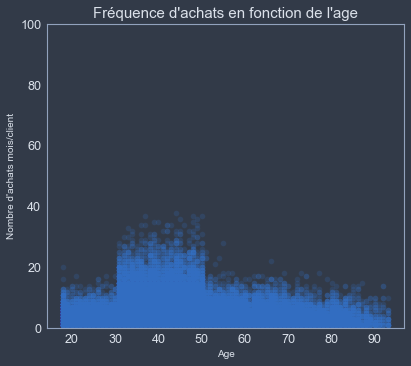

In [55]:
#création d'une colonne mois
df_transactions_m['month'] = pd.to_datetime(df_transactions_m['Day'])
df_transactions_m['month'] = df_transactions_m['month'].dt.strftime('%B - %Y')

#regroupement des fréquences par mois et par client
df_age_fréq_achat_mois=df_transactions_m.groupby(['age','client_id','month'])['price'].count().reset_index()
df_age_fréq_achat_mois.columns=['age','client_id','month','number_transactions']

#corrélation
corr_age_fréq_achat_mois=(st.pearsonr(df_age_fréq_achat_mois['age'],
                                      df_age_fréq_achat_mois['number_transactions'])[0]).round(5)
#plt.text(0.45, 0.85, "Coefficient de corrélation = {}".format(corr_age_fréq_achat_mois),transform=plt.gca().transAxes)

#graphique
plt.ylim(0, 100)
plt.plot(df_age_fréq_achat_mois['age'],
         df_age_fréq_achat_mois['number_transactions'],'o',alpha=0.2)
plt.xlabel("Age",fontsize=10)
plt.ylabel("Nombre d'achats mois/client",fontsize=10)
plt.title("Fréquence d'achats en fonction de l'age",fontsize=15)
plt.savefig("Fréquence d'achats en fonction de l'age")
plt.show()

Le graphique fait apparaître une fréquence d'achats par mois bien plus important pour la tranche d'âge 30-50 ans.

In [56]:
#passons par une ANOVA désormais
#créons ainsi différentes catégories d'âge

def cat_age(row):
    if row['client_id'] == 'c_1609':
        val = 'top_4'
    elif row['client_id'] == 'c_4958':
        val = 'top_4'
    elif row['client_id'] == 'c_6714':
        val = 'top_4'
    elif row['client_id'] == 'c_3454':
        val = 'top_4'
    elif row['age'] >= 19 and row['age'] <= 30:
        val = '19-30' 
    elif row['age'] >= 31 and row['age'] <= 50:
        val = '31-50' 
    elif row['age'] >= 51 :
        val = '51-100' 
    else:
        val = str(row['age'])
    return val

df_transac_m['categ_age'] = df_transac_m.apply(cat_age, axis=1)

In [58]:
df_transac_m.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,Day,categ_age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0.0,f,1977,45,2021-04-10,31-50
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2.0,f,2000,22,2022-02-03,19-30
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1.0,f,1979,43,2021-09-23,31-50
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0.0,m,1963,59,2021-10-17,51-100
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0.0,f,1980,42,2021-07-17,31-50


Statistique qui permet de calculer la variance intercluster, sur la variance totale; elle est liée au calcul de corrélation.

$$ \frac{Var inter}{Var totale} $$

In [57]:
X = "categ_age" # qualitative
Y = "price" # quantitative

sous_echantillon = df_transac_m[df_transac_m["price"] > 0] # On enlève les valeurs nulles

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.2078756001312045

Le mesure d'Eta carré est proche de zéro ; les moyennes par catégories d'âge sont donc assez équivalentes, et il ne semble pas y avoir à priori de relation entre la fréquence d'achat des clients et leur age.

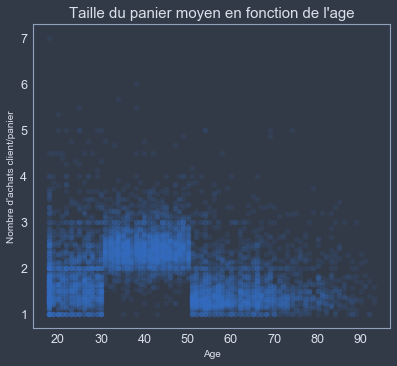

In [59]:
#Visualisation par age

df_age_panier_moyen=(df_transactions_m.groupby(['age','client_id','session_id'])['price'].count().reset_index()).groupby(['age','client_id'])['price'].mean().reset_index()
df_age_panier_moyen.columns=['age','client_id','number_orders']

#graphique
plt.plot(df_age_panier_moyen['age'],df_age_panier_moyen['number_orders'],'o',alpha=0.1)
plt.xlabel("Age",fontsize=10)
plt.ylabel("Nombre d'achats client/panier",fontsize=10)
plt.title("Taille du panier moyen en fonction de l'age",fontsize=15)
plt.savefig("Taille du panier moyen en fonction de l'age")
plt.show()

On remarque aussi que la tranche des 30 à 50 ans consomment très rarement en dessous de 2 articles.

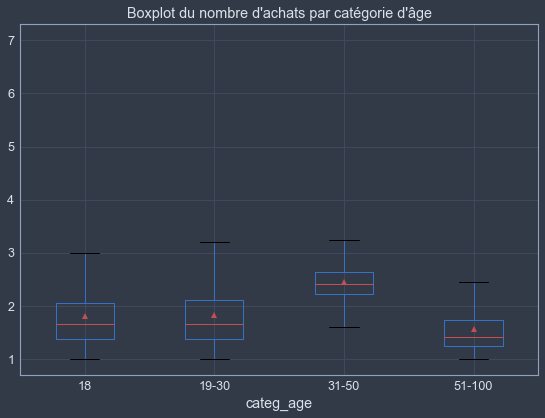

In [60]:
#Visualisation par catégorie d'âge

df_cat_age_panier_moyen=(df_transac_m.groupby(['age','categ_age','client_id','session_id'])['price'].count().reset_index()).groupby(['age','categ_age','client_id'])['price'].mean().reset_index()
df_cat_age_panier_moyen.columns=['age','categ_age','client_id','number_orders']
df_cat_age_panier_moyen=df_cat_age_panier_moyen[['categ_age','client_id','number_orders']]
df_cat_age_panier_moyen.head()

df_cat_age_panier_moyen[df_cat_age_panier_moyen['categ_age']!='top_4'].boxplot(column="number_orders",by= "categ_age",figsize= (9,6.5),showmeans=True)   

plt.title("Boxplot du nombre d'achats par catégorie d'âge")
plt.suptitle("")
plt.savefig("Boxplot du nombre d'achats par catégorie d'âge")
plt.show()

In [61]:
X = "categ_age" # qualitative
Y = "number_orders" # quantitative
    
eta_squared(df_cat_age_panier_moyen[X],df_cat_age_panier_moyen[Y])

0.3755607293274468

La mesure d'Eta carré (autour de 0.4) montre que les moyennes par classes sont assez différentes: il existe a priori une relation entre les catégories d'âge et la taille du panier moyen.

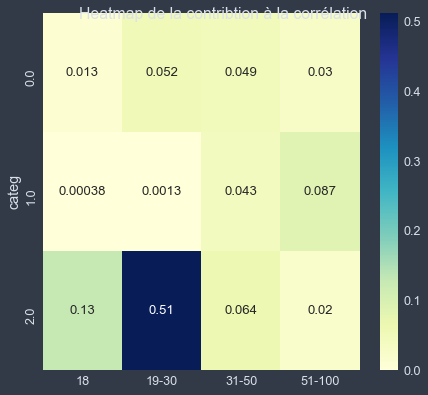

Xi_n= 137122.95108766825


In [62]:
#création du tableau de contingence dans cont

df2_4=df_transac_m[df_transac_m.categ_age!='top_4']

c = df2_4[['categ','categ_age']].pivot_table(index=['categ'],columns=['categ_age'],aggfunc=len)
cont = c.copy()

tx = df2_4['categ'].value_counts()
ty = df2_4['categ_age'].value_counts()

cont.loc[:,"Total"] = tx
cont.loc["total",:] = ty
cont.loc["total","Total"] = len(df_transac_m)

#création du tableau dans le cas d'indépendance entre categ et categ_age
tx = pd.DataFrame(tx)
ty = pd.DataFrame(ty)
tx.columns = ["foo"]
ty.columns = ["foo"]
n = len(df2_4)
indep = tx.dot(ty.T) / n

c = c.fillna(0) 
mesure = (c-indep)**2/indep
xi_n = mesure.sum().sum()
sns.heatmap(mesure/xi_n,annot=mesure/xi_n,cmap="YlGnBu")
plt.tight_layout()
plt.suptitle("Heatmap de la contribtion à la corrélation")
plt.title("")
plt.savefig("Heatmap de la contribtion à la corrélation")
plt.show()

print('Xi_n=',xi_n)

In [63]:
chi2, pvalue, degrees, expected = chi2_contingency(c)
chi2, degrees, pvalue

(137099.95489648922, 6, 0.0)

La catégorie des 19-30 ans est source principale de non-indpendance entre les variables catégorie d'age et catégorie de produit: ces deux dernières apparaissent être bien corrélées étant donnée la mesure importante du chi2. Le test est significatif. 